In [3]:
import json
import os
import subprocess
import glob

import numpy as np
from pathlib import Path
import yaml
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json
import copy

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

import ast

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm
from matplotlib.ticker import FuncFormatter

import uproot 


In [4]:
def calculate_xpcrit(name, line, p0c):
    bending_radius = line[name].bending_radius
    dp = 1.92e-10 
    pot_crit = 21.34
    eta = 0.9
    Rcrit = p0c/(2*np.sqrt(eta)*pot_crit) * (dp/2)
    xp_crit = np.sqrt(2*eta*pot_crit/p0c)*(1 - Rcrit/bending_radius)
    return xp_crit

dp = 1.92e-10 
pot_crit = 21.34
eta = 0.9

def calculate_Rc(pc, bending_radius = 10 ):
    return  pc/(2*np.sqrt(eta)*pot_crit) * (dp/2)

def calculate_chann_prob(pc, bending_radius = 10 ):
    Rc = calculate_Rc(pc, bending_radius)
    return np.sqrt(eta)*(1 - Rc/bending_radius)


def calculate_dechanneling_length(pc, bending_radius = 10 ): #GeV
    XC_PROTON_MASS = 938.271998
    XC_ELECTRON_MASS =  0.51099890
    XC_SCREENING = 0.194e-10
    XC_PLANE_DISTANCE = 1.920e-10 
    XC_CRADE = 2.817940285e-15
    exenergy=173.0e-9

    momentum = pc*1.0e3   # [MeV]
    energy   = np.sqrt(np.power(momentum, 2.) + np.power(XC_PROTON_MASS, 2.)) # [MeV]
    gammar   = energy/XC_PROTON_MASS

    const_dech = 256.0/(9.*np.power(np.pi, 2.)) / (np.log(2.*XC_ELECTRON_MASS*gammar/exenergy/1000) - 1.)
    const_dech *= (XC_SCREENING*XC_PLANE_DISTANCE)/(XC_CRADE*XC_ELECTRON_MASS)*1.0e3 # [m/GeV]
    Rc = calculate_Rc(pc*1e9, bending_radius)
    const_dech *= (1-Rc/bending_radius )**2 *pc #[m]

    return const_dech

In [5]:
10*2*np.sqrt(eta)*pot_crit/(dp/2)/1e12

4.217687829249575

In [6]:
ut = 0.075e-10
en_c = 5.7e9/1e-2
x_c = dp/2-0.6565*ut
x_c, np.sqrt(eta)*dp/2, dp/2-0.194e-10, dp/2-2*ut

(9.107625e-11, 9.107359661284932e-11, 7.66e-11, 8.1e-11)

In [7]:
(x_c/(dp/2))**2

0.9000524429321289

In [8]:
9*2*np.sqrt(eta)*pot_crit/(x_c)/1e12

4.001133428826542

In [9]:
10*en_c/1e12

5.7

In [229]:
dp = 1.92e-10 
aTF = 0.194e-10
uT = 0.075e-10
xc = dp/2 -0.6565*uT
eta = (xc*2/dp)**2
p0c = 450e9
bending_radius = 10
pot_crit = 21.34
Rcrit = p0c/(2*eta*pot_crit) * xc
xp_crit = np.sqrt(2*eta*pot_crit/p0c)*(1 - Rcrit/bending_radius)
Rcrit, xp_crit

(1.0669042092666543, 8.253570152706948e-06)

In [230]:
dp = 1.92e-10 
Rcrit = p0c/(2*np.sqrt(eta)*pot_crit) * (dp/2)
xp_crit = np.sqrt(2*eta*pot_crit/p0c)*(1 - Rcrit/bending_radius)
Rcrit, xp_crit

(1.0669042092666543, 8.253570152706948e-06)

In [85]:
75/5

15.0

In [167]:
15*2*np.sqrt(eta)*pot_crit/(x_c)/1e12

6.6685557147109025

In [86]:
def chann_eff(p0c, df= None, plot=False, cry = "TCCS", ):
    print(f"\n----\np0c: {p0c/1e9} GeV")

    context = xo.ContextCpu()
    if cry == "TCCS":
        coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_radius = 80.00,
                            width=0.002, height=35.0e-3, side='+', lattice='strip', jaw=0.001)
    elif cry == "TCCP":
        coll = xc.EverestCrystal(length=0.070, material=xc.materials.SiliconCrystal, bending_radius = 10.00,
                            width=0.002, height=9.0e-3, side='+', lattice='strip', jaw=0.001)
    elif cry == "DAN":
        coll = xc.EverestCrystal(length=0.075, material=xc.materials.SiliconCrystal, bending_radius = 15.00,
                            width=0.002, height=9.0e-3, side='+', lattice='strip', jaw=0.001)
    line =  xt.Line(elements={'coll': coll}, element_names=['coll'])
    xp_crit = calculate_xpcrit('coll', line, p0c)
    if xp_crit < 0:
        print("xp_crit < 0")
        return
    num_part = int(1e6)
    x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
    #px_init  = np.random.uniform(low=-10.e-6, high=10.e-6, size=num_part)
    px_init  = np.zeros(num_part) #np.random.uniform(low=-0.001e-6, high=0.001e-6, size=num_part)
    y_init   = np.random.normal(loc=0., scale=1e-3, size=num_part)
    py_init  = np.random.normal(loc=0., scale=5.e-6, size=num_part)
    part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=p0c, _context=context, at_element=0)
    part_init = part.copy()
    
    line.build_tracker()
    impacts = xc.InteractionRecord.start(line=line)  #capacity=int(2e7)
    line.track(part)
    line.scattering.disable()
    impacts.stop()
    line.discard_tracker()

    part_after = part.copy()
    if plot:
        mask = (part.state > 0 ) & ( part.px - part_init.px < 10000.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2
        plt.figure(figsize=(8,5))
        _ = plt.hist2d(part_init.px[mask]*1.e6, part.px[mask]*1.e6 - part_init.px[mask]*1.e6 , 500, norm=mpl.colors.LogNorm())
        plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
        plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
    
    cry_imp = impacts.interactions_per_collimator('coll').reset_index()
    cry_imp.int = cry_imp.int.apply(lambda x: str(x))

    n_abs = cry_imp['int'].apply(lambda x: 'A'  in x).sum()
    idx_cry = 0
    cry_name = 'coll'
    miscut_cry = 0.00
   
    sim_chann_eff = None
    if len(cry_imp) > 0:
        unique_values, counts = np.unique(cry_imp['int'], return_counts=True)
        summary_int = pd.DataFrame({'int': unique_values,'counts': counts})
        summary_int.int = summary_int.int.astype(str)
        if "['CH']" in summary_int.int.to_list():
            sim_chann_eff = summary_int[summary_int['int'] == "['CH']"].counts.iloc[0] / sum((impacts.at_element == idx_cry) & (impacts.interaction_type == "Enter Jaw L") 
                                                                                                & (impacts.px_before  - miscut_cry < calculate_xpcrit(cry_name, line, p0c))&(impacts.px_before - miscut_cry > - calculate_xpcrit(cry_name, line, p0c)))
            sim_chann_eff_total = summary_int[summary_int['int'] == "['CH']"].counts.iloc[0] / sum((impacts.at_element == idx_cry) & (impacts.interaction_type == "Enter Jaw L"))                                                                                    
        else: 
            sim_chann_eff = 0
            sim_chann_eff_total = 0

    dech_length = calculate_dechanneling_length(p0c*1e-9, coll.bending_radius)
    chann_prob = calculate_chann_prob(p0c, coll.bending_radius)
    print(f"\nDechanneling length: {dech_length} m")
    print(f"Channeling probability: {chann_prob}")
    print(f"Part absorbed: {n_abs} ")
    print("channeling efficiency: ", sim_chann_eff*100 )
    print("Total channeling efficiency: ", sim_chann_eff_total*100)
    print("Xp_crit: ", xp_crit*1e6, 'urad\n ----')
    
    if df is not None:
        df_entry = {'abs': n_abs, 'chann_eff': sim_chann_eff, 'chann_eff_total': sim_chann_eff_total,  'xp_crit': calculate_xpcrit(cry_name, line, p0c), 'dech_length': dech_length, 'chann_prob': chann_prob}
        df[p0c] = df_entry
    del line, coll, part, impacts, context


In [43]:
1/0.8587114142641971

1.164535585982479


----
p0c: 4200.0 GeV
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.

Dechanneling length: 0.21985691060517423 m
Channeling probability: 0.3188801115462963
Part absorbed: 29336 
channeling efficiency:  22.37616608075084
Total channeling efficiency:  22.37616608075084
Xp_crit:  1.0165178130729928 urad
 ----


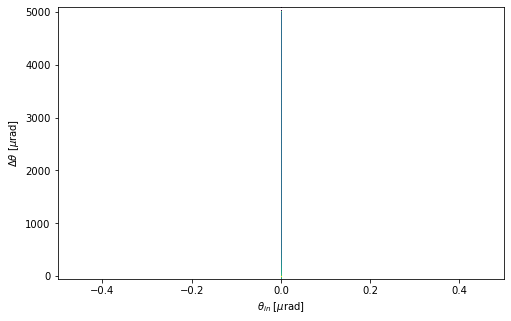

In [87]:
chann_eff(42e11, plot=True, cry = "DAN")

In [143]:
np.arange(100e9, 4400e9, 200e9)

array([1.0e+11, 3.0e+11, 5.0e+11, 7.0e+11, 9.0e+11, 1.1e+12, 1.3e+12,
       1.5e+12, 1.7e+12, 1.9e+12, 2.1e+12, 2.3e+12, 2.5e+12, 2.7e+12,
       2.9e+12, 3.1e+12, 3.3e+12, 3.5e+12, 3.7e+12, 3.9e+12, 4.1e+12,
       4.3e+12])

In [151]:
len(np.arange(100e9, 1000e9, 10e9) )

90

In [193]:
len(np.arange(100e9, 7000e9, 100e9) )

69

In [197]:
energies = np.arange(100e9, 7000e9, 100e9) #np.arange(100e9, 1000e9, 10e9) #np.arange(4e11, 70e11, 2e11)
df_aligned_DAN_full = {}

for en in energies:
    chann_eff(en, df_aligned_DAN_full, cry = "DAN")


----
p0c: 100.0 GeV
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.

Dechanneling length: 0.058457568172644546 m
Channeling probability: 0.9336879840861276
Part absorbed: 13395 
channeling efficiency:  47.05220218101919
Total channeling efficiency:  47.05220218101919
Xp_crit:  19.289189298524846 urad
 ----

----
p0c: 200.0 GeV
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.

Dechanneling length: 0.10717630941611872 m
Channeling probability: 0.9186926701217415
Part absorbed: 12604 
channeling efficiency:  58.50791208881613
Total channeling efficiency:  58.50791208881613
Xp_crit:  13.42046175821449 urad
 ----

----
p0c: 300.0 GeV
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.

Dechanneling length: 0.15087024036770647 m
Channeling pr

In [225]:
"""
chann_eff(90e9, df_aligned_DAN_full, cry = "DAN")
chann_eff(80e9, df_aligned_DAN_full, cry = "DAN")
chann_eff(70e9, df_aligned_DAN_full, cry = "DAN")
chann_eff(60e9, df_aligned_DAN_full, cry = "DAN")
chann_eff(50e9, df_aligned_DAN_full, cry = "DAN")
chann_eff(40e9, df_aligned_DAN_full, cry = "DAN")
chann_eff(30e9, df_aligned_DAN_full, cry = "DAN")
chann_eff(20e9, df_aligned_DAN_full, cry = "DAN")
chann_eff(1e9, df_aligned_DAN_full, cry = "DAN")
chann_eff(10e9, df_aligned_DAN_full, cry = "DAN")"""

'\nchann_eff(90e9, df_aligned_DAN_full, cry = "DAN")\nchann_eff(80e9, df_aligned_DAN_full, cry = "DAN")\nchann_eff(70e9, df_aligned_DAN_full, cry = "DAN")\nchann_eff(60e9, df_aligned_DAN_full, cry = "DAN")\nchann_eff(50e9, df_aligned_DAN_full, cry = "DAN")\nchann_eff(40e9, df_aligned_DAN_full, cry = "DAN")\nchann_eff(30e9, df_aligned_DAN_full, cry = "DAN")\nchann_eff(20e9, df_aligned_DAN_full, cry = "DAN")\nchann_eff(1e9, df_aligned_DAN_full, cry = "DAN")\nchann_eff(10e9, df_aligned_DAN_full, cry = "DAN")'

In [195]:
"""chann_eff(90e9, df_aligned_TCCP_full, cry = "TCCP")
chann_eff(80e9, df_aligned_TCCP_full, cry = "TCCP")
chann_eff(70e9, df_aligned_TCCP_full, cry = "TCCP")
chann_eff(60e9, df_aligned_TCCP_full, cry = "TCCP")
chann_eff(50e9, df_aligned_TCCP_full, cry = "TCCP")
chann_eff(40e9, df_aligned_TCCP_full, cry = "TCCP")
chann_eff(30e9, df_aligned_TCCP_full, cry = "TCCP")
chann_eff(20e9, df_aligned_TCCP_full, cry = "TCCP")
chann_eff(1e9, df_aligned_TCCP_full, cry = "TCCP")
chann_eff(10e9, df_aligned_TCCP_full, cry = "TCCP")"""

'chann_eff(90e9, df_aligned_TCCP_full, cry = "TCCP")\nchann_eff(80e9, df_aligned_TCCP_full, cry = "TCCP")\nchann_eff(70e9, df_aligned_TCCP_full, cry = "TCCP")\nchann_eff(60e9, df_aligned_TCCP_full, cry = "TCCP")\nchann_eff(50e9, df_aligned_TCCP_full, cry = "TCCP")\nchann_eff(40e9, df_aligned_TCCP_full, cry = "TCCP")\nchann_eff(30e9, df_aligned_TCCP_full, cry = "TCCP")\nchann_eff(20e9, df_aligned_TCCP_full, cry = "TCCP")\nchann_eff(1e9, df_aligned_TCCP_full, cry = "TCCP")\nchann_eff(10e9, df_aligned_TCCP_full, cry = "TCCP")'

In [205]:
save_df(df_aligned_DAN_full, "df_aligned_DAN_full")

In [216]:
def plot_df(df):
    if isinstance(df, pd.DataFrame):
        df = df.sort_values(by='energy')
        x = df.energy
        y = df['chann_eff']
        y_2 = df['chann_eff_total']
        dech_length = df['dech_length']
        chann_prob = df['chann_prob']
        xp_crit = df['xp_crit']
    elif isinstance(df, dict):
        df = {key: df[key] for key in sorted(df.keys())}
        x = np.array([key for key in df.keys()])
        y = np.array([df[key]['chann_eff']for key in df.keys()])
        y_2 = np.array([df[key]['chann_eff_total']for key in df.keys()])
        dech_length = np.array([df[key]['dech_length']for key in df.keys()])
        chann_prob = np.array([df[key]['chann_prob']for key in df.keys()])
        xp_crit = np.array([df[key]['xp_crit']for key in df.keys()])
    fig, ax= plt.subplots(figsize=(8,5))
    ax.plot(x, y, label='chann_eff', marker='o')
    #ax.plot(x, y_2)
    ax.plot(x, chann_prob, label='chann_prob')
    ax.plot(x, dech_length, label='dech_length')
    ax2 = ax.twinx()
    ax2.plot(x, xp_crit, color='red', label='xp_crit')
    ax.legend()
    ax2.legend(loc='upper center')
    return ax, ax2


def save_df(df, name):
    dataframe = pd.DataFrame(df).T.reset_index()
    dataframe.rename(columns={'index': 'energy'}, inplace=True)
    dataframe.to_hdf('./Outputdata/ChannEff.h5', key=name, mode = 'a', format='table',complevel=9, complib='blosc')

def load_df(name):
    df = pd.read_hdf('./Outputdata/ChannEff.h5', key=name)
    df = df.sort_values(by='energy')
    return df

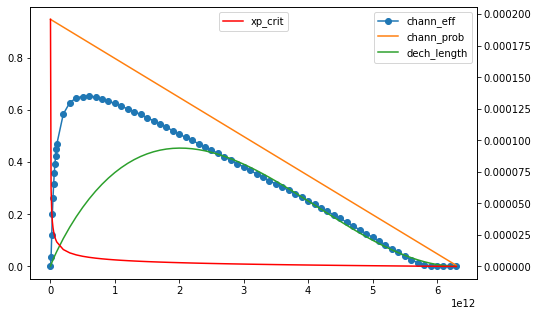

In [211]:
ax = plot_df(df_aligned_DAN_full)
#ax[0].set_yscale('log')

,energy,abs,chann_eff,chann_eff_total,xp_crit,dech_length,chann_prob
5,4.000000e+11,12936.0,0.623897,0.623897,0.000009,0.177828,0.858711


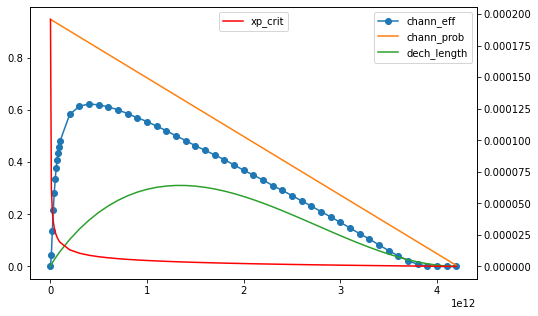

In [ ]:
TCCP_data = load_df("df_aligned_TCCP_full")
plot_df(TCCP_data)
TCCP_data[TCCP_data.chann_eff == max(TCCP_data.chann_eff)]


In [228]:
np.sqrt(0.9)*21.34

20.244901580397965

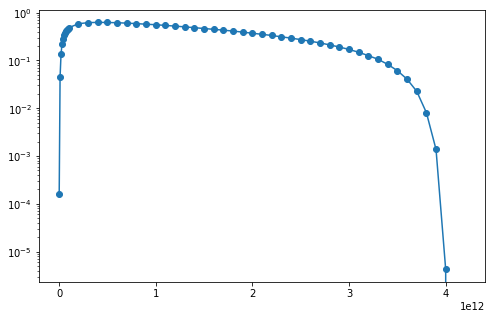

In [220]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(TCCP_data.energy, TCCP_data.chann_eff, label='chann_eff', marker='o')
ax.set_yscale('log')

,energy,abs,chann_eff,chann_eff_total,xp_crit,dech_length,chann_prob
5,6.000000e+11,13481.0,0.655859,0.655859,0.000007,0.259096,0.858711


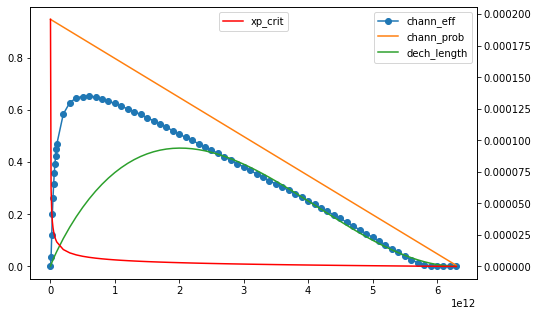

In [224]:
DAN_data = load_df("df_aligned_DAN_full")
plot_df(DAN_data)
DAN_data[DAN_data.chann_eff == max(DAN_data.chann_eff)]

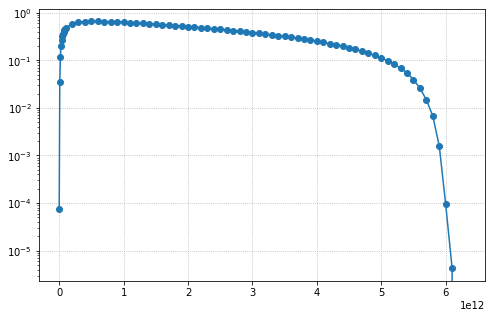

In [223]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(DAN_data.energy, DAN_data.chann_eff, label='chann_eff', marker='o')
ax.set_yscale('log')
ax.grid(linestyle=':')

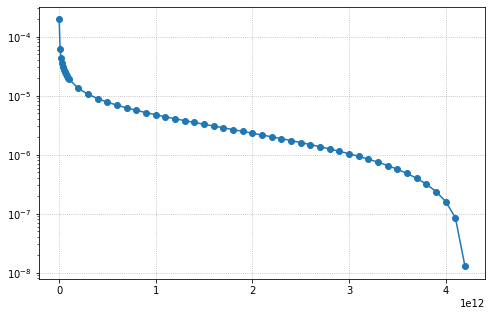

In [232]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(TCCP_data.energy, TCCP_data.xp_crit, label='chann_eff', marker='o')
ax.set_yscale('log')
ax.grid(linestyle=':')

In [8]:
p0c = 3000e9 # 1000e9 3000e9 4500e9
plot = True
num_part = int(1e6)
context = xo.ContextCpu()

In [9]:
df = pd.DataFrame({
    450: [0.000759, 0.000931, 0.000020, 0.000013],
    1000: [0.000512, 0.000618, 0.000013, 0.000008],
    3000: [0.000302, 0.000340, 0.000008, 0.000005]
}, index=['x', 'y', 'px', 'py'])
df

,450,1000,3000
x,0.000759,0.000512,0.000302
y,0.000931,0.000618,0.000340
px,0.000020,0.000013,0.000008
py,0.000013,0.000008,0.000005


In [10]:
en = int(p0c/1e9)
x_init   = np.random.normal(loc=1e-3, scale=df[en]['x'], size=num_part)
#px_init  = np.random.uniform(low=-10.e-6, high=10.e-6, size=num_part)
px_init  = np.random.normal(loc=0., scale=df[en]['px'], size=num_part)
y_init   = np.random.normal(loc=0., scale=df[en]['y'], size=num_part)
py_init  = np.random.normal(loc=0., scale=df[en]['py'], size=num_part)
part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=p0c, _context=context, at_element=0)
part_init = part.copy()


----
p0c: 3000.0 GeV
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.

Part absorbed: 32987 
channeling efficiency:  13.016957423447604
Total channeling efficiency:  1.3432196988770835
Xp_crit:  1.0330809794226892 
 ----


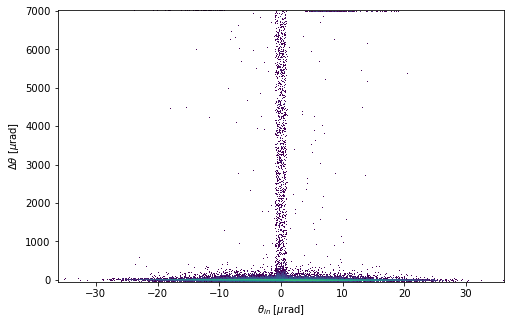

In [11]:
print(f"\n----\np0c: {p0c/1e9} GeV")


coll = xc.EverestCrystal(length=0.070, material=xc.materials.SiliconCrystal, bending_radius = 10.00,
                    width=0.002, height=9.0e-3, side='+', lattice='strip', jaw=0.001)
line =  xt.Line(elements={'coll': coll}, element_names=['coll'])
num_part = int(1e6)


line.build_tracker()
impacts = xc.InteractionRecord.start(line=line)  #capacity=int(2e7)
line.track(part)
line.scattering.disable()
impacts.stop()
line.discard_tracker()

part_after = part.copy()
if plot:
    mask = (part.state > 0 ) & ( part.px - part_init.px < 10000.e-6) & ( part.px - part_init.px > -50.e-6) #& mask2
    plt.figure(figsize=(8,5))
    _ = plt.hist2d(part_init.px[mask]*1.e6, part.px[mask]*1.e6 - part_init.px[mask]*1.e6 , 500, norm=mpl.colors.LogNorm())
    plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
    plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')

cry_imp = impacts.interactions_per_collimator('coll').reset_index()
cry_imp.int = cry_imp.int.apply(lambda x: str(x))

n_abs = cry_imp['int'].apply(lambda x: 'A'  in x).sum()
idx_cry = 0
cry_name = 'coll'
miscut_cry = 0.00

sim_chann_eff = None
if len(cry_imp) > 0:
    unique_values, counts = np.unique(cry_imp['int'], return_counts=True)
    summary_int = pd.DataFrame({'int': unique_values,'counts': counts})
    summary_int.int = summary_int.int.astype(str)
    if "['CH']" in summary_int.int.to_list():
        sim_chann_eff = summary_int[summary_int['int'] == "['CH']"].counts.iloc[0] / sum((impacts.at_element == idx_cry) & (impacts.interaction_type == "Enter Jaw L") 
                                                                                            & (impacts.px_before  - miscut_cry < calculate_xpcrit(cry_name, line, p0c))&(impacts.px_before - miscut_cry > - calculate_xpcrit(cry_name, line, p0c)))
        sim_chann_eff_total = summary_int[summary_int['int'] == "['CH']"].counts.iloc[0] / sum((impacts.at_element == idx_cry) & (impacts.interaction_type == "Enter Jaw L"))                                                                                    
print(f"\nPart absorbed: {n_abs} ")
print("channeling efficiency: ", sim_chann_eff*100 )
print("Total channeling efficiency: ", sim_chann_eff_total*100)
print("Xp_crit: ", calculate_xpcrit(cry_name, line, p0c)*1e6, '\n ----')

p0c = 450
Part absorbed: 29359 
channeling efficiency:  47.76376585913767
Total channeling efficiency:  15.249913401389653
Xp_crit:  8.25330097732552 

p0c = 1000
Part absorbed: 30391 
channeling efficiency:  43.24733352551168
Total channeling efficiency:  12.243190859940835
Xp_crit:  4.728277264321725 

p0c = 3000

Part absorbed: 32987 
channeling efficiency:  13.016957423447604
Total channeling efficiency:  1.3432196988770835
Xp_crit:  1.0330809794226892 